In [1]:
import os
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scvi import set_seed

import matplotlib.pyplot as plt

sns.set(context="notebook", font_scale=1.15, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598", "#CFDD45"]
sns.set_palette(sns.color_palette(colors))

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

set_seed(0)

In [2]:
sns.set(context="notebook", font_scale=1.3, style="ticks")
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True

sc.settings._vector_friendly = True
DPI = 300

import matplotlib.colors


In [3]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206])

[2020-04-29 13:55:01,300] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 13:55:01,305] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 13:55:01,418] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 13:55:01,531] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells
[2020-04-29 13:55:02,530] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 13:55:02,533] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 13:55:02,640] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 13:55:02,748] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-04-29 13:55:03,044] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-04-29 13:55:03,293] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 13:55:03,475] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 1

In [4]:
post_adata = anndata.read("sln_all_intersect_post_adata.h5ad")

In [5]:
new_annots = pd.read_csv("annotations/annotations_subclustered.csv")

In [6]:
annotations = {
    "0": "CD4 T",
    "1": "Mature B",
    "2": "CD8 T",
    "3": "Transitional B",
    "4": "Mature B",
    "5": "Mature B",
    "6": "CD122+ CD8 T",
    "7": "Mature B",
    "8": "Ifit3-high B",
    "9": "Mature B",
    "10,0": "Tregs",
    "10,1": "ICOS-high Tregs",
    "10,2": "Tregs",
    "11": "MZ B",
    "12,0": "NKT",
    "12,1": "NK",
    "13": "B1 B",
    "14": "Ifit3-high CD4 T",
    "15,0": "cDC2s",
    "15,1": "cDC1s",
    "15,2": "Migratory DCs",
    "16,0": "B-macrophage doublets",
    "16,1": "MZ/Marco-high macrophages",
    "16,2": "Red-pulp macrophages",
    "16,3": "Erythrocytes",
    "17": "Low quality B cells",
    "18": "Ifit3-high CD8 T",
    "19": "Cycling B/T cells",
    "20,0": "Ly6-high mono",
    "20,1": "Ly6-low mono",
    "21": "B doublets",
    "22": "GD T",
    "23": "T doublets",
    "24,0": "B-CD8 T cell doublets",
    "24,1": "Erythrocytes",
    "24,2": "Low quality T cells",
    "25": "B-CD4 T cell doublets",
    "26": "Neutrophils",
    "27": "Activated CD4 T",
    "28": "pDCs",
    "29": "Low quality T cells",
    "30": "Neutrophils",
    "31": "Plasma B",
}

post_adata.obs["leiden_subclusters"] = pd.Categorical(
    new_annots["leiden_subclusters"].values.ravel()
)
post_adata.obs["labels"] = pd.Categorical(
    [annotations[a] for a in new_annots["leiden_subclusters"].values.ravel()]
)

In [7]:
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in post_adata.obs["leiden_subclusters"]
]

In [8]:
for i in range(post_adata.obsm["X_totalVI"].shape[1]):
    post_adata.obs["Z_{}".format(i)] = post_adata.obsm["X_totalVI"][:, i]

In [9]:
post_adata[include_cells].obs["labels"]

index
0                   NKT
1          CD122+ CD8 T
2        Transitional B
3              Mature B
4                 CD4 T
              ...      
32643          Mature B
32644             CD8 T
32645             CD4 T
32646              B1 B
32647             CD4 T
Name: labels, Length: 30474, dtype: category
Categories (27, object): [Activated CD4 T, B1 B, CD122+ CD8 T, CD4 T, ..., Tregs, cDC1s, cDC2s, pDCs]

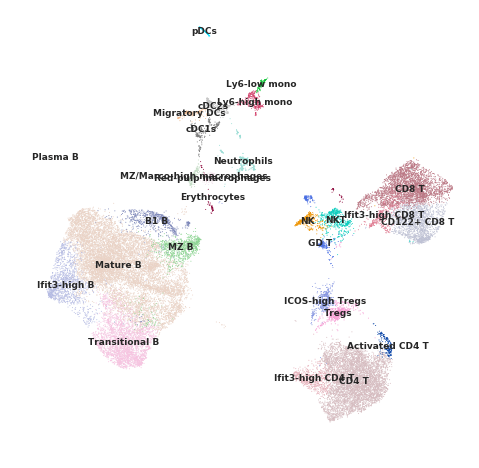

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(
    post_adata[include_cells], 
    color="labels",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="xx-small",
    ax=ax,
#     s=4,
#     palette=iwanthue
)
fig.savefig("figures/sln_all_umap_on_data.pdf", dpi=DPI, bbox_inches='tight')

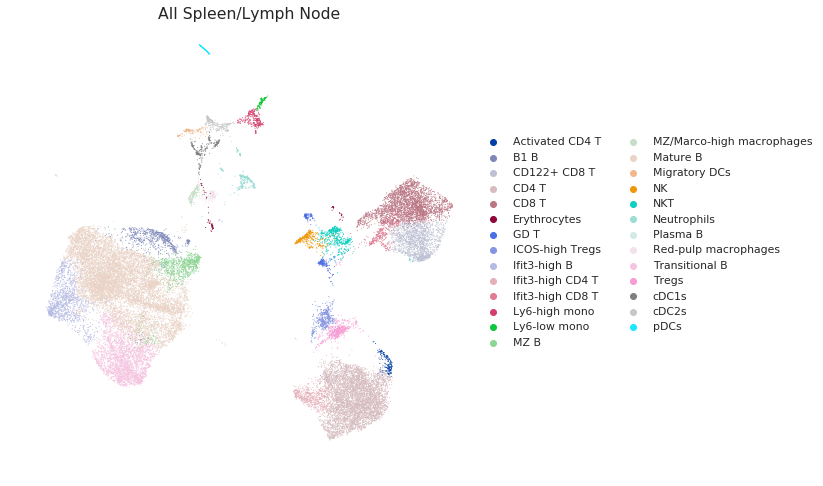

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(
    post_adata[include_cells], 
    color="labels",
    frameon=False,
    title="All Spleen/Lymph Node",
    legend_fontsize="x-small",
    ax=ax,
)

Trying to set attribute `.obs` of view, making a copy.
... storing 'lane' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence,

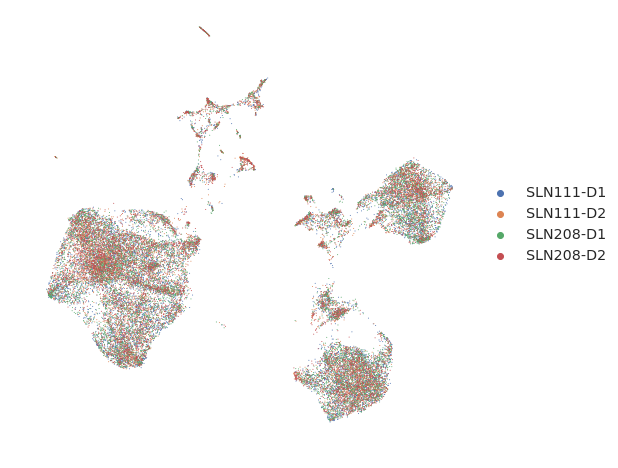

In [12]:
adata_total = anndataset_111.concatenate(anndataset_206)
lane_names = ["SLN111-D1", "SLN111-D2", "SLN208-D1", "SLN208-D2"]
post_adata.obs["lane"] = [lane_names[b] for b in dataset.batch_indices.ravel()]
post_adata.obs["tissue"] = adata_total.obs["seurat_hash_id"].values
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(
    post_adata[include_cells], 
    color="lane",
    frameon=False,
    title="",
#     legend_loc="on data",
#     legend_fontsize="xx-small",
    ax=ax,
)
fig.savefig("figures/sln_all_umap_batch.pdf", dpi=DPI, bbox_inches='tight')

Trying to set attribute `.obs` of view, making a copy.
... storing 'lane' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


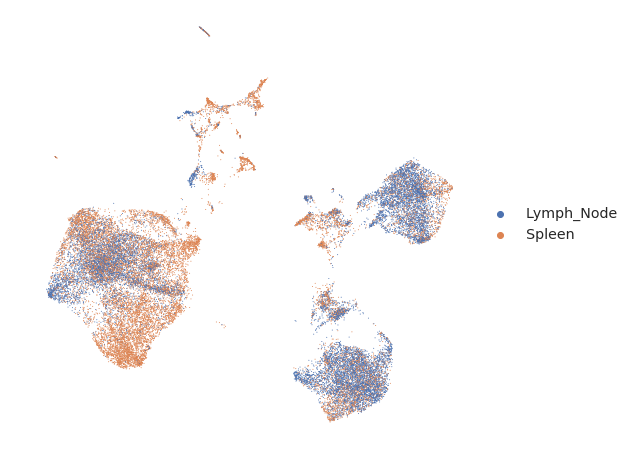

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(
    post_adata[include_cells], 
    color="tissue",
    frameon=False,
    title="",
#     legend_loc="on data",
#     legend_fontsize="xx-small",
    ax=ax,
)
fig.savefig("figures/sln_all_umap_tissue.pdf", dpi=DPI, bbox_inches='tight')

In [14]:
import pandas as pd
df = pd.DataFrame()
df["leiden_0.8"] = post_adata.obs["leiden_totalVI_0.8"].values
df["cell_types"] = post_adata.obs["labels"].values

In [15]:
adata_total = adata_total[:, adata_total.var["highly_variable"]].copy()
adata_total = adata_total[include_cells]

In [16]:
adata_total.obs["labels"] = post_adata[include_cells].obs["labels"].values

Trying to set attribute `.obs` of view, making a copy.


In [17]:
sc.pp.normalize_total(adata_total, target_sum=1e4)

In [18]:
sc.pp.log1p(adata_total)

In [19]:
np.unique(adata_total.obs["labels"])

array(['Activated CD4 T', 'B1 B', 'CD122+ CD8 T', 'CD4 T', 'CD8 T',
       'Erythrocytes', 'GD T', 'ICOS-high Tregs', 'Ifit3-high B',
       'Ifit3-high CD4 T', 'Ifit3-high CD8 T', 'Ly6-high mono',
       'Ly6-low mono', 'MZ B', 'MZ/Marco-high macrophages', 'Mature B',
       'Migratory DCs', 'NK', 'NKT', 'Neutrophils', 'Plasma B',
       'Red-pulp macrophages', 'Transitional B', 'Tregs', 'cDC1s',
       'cDC2s', 'pDCs'], dtype=object)

In [30]:
label_groups = {
    "Activated CD4 T":["Itm2a", "Cd69"],
    'B1 B': ["Bhlhe41"],
    'cDC1s': ["Clec9a", "Cd8a", "Xcr1"],
    'cDC2s': ["Itgax", "Cd4"],
    'Tregs': ["Foxp3"],
    'Ifit3-high B' : ["Ifit3"],
    'Ly6-high mono' : ["Ly6c2", "Fn1", "F13a1"],
    'Ly6-low mono' : ["Cd36", "Cd300e", "Fabp4"],
    'MZ/Marco-high macrophages': ["Cd209b", "Marco"],
    'Migratory DCs': ["Slco5a1", "Anxa3", "Nudt17", "Adcy6", "Cacnb3"],
    'NK': ["Gzma", "Ncr1"],
    "NKT": ["Cd3e", "Ccl5", "Klrd1"],
    'pDCs': ["Siglech", "Irf8", "Runx2"],
    'Plasma B': ["Jchain"],
    "Neutrophils": ["S100a8"],
    'Red-pulp macrophages': ["C1qa", "C1qb", "Hmox1", "Vcam1"],
    "Erythrocytes": ["Hbb-bs", "Hbb-bt"],
    "GD T": ["Cd3e", "Maf", "Il17re", "Tcrg-C1", "Tcrg-C2"]
}
label_groups_new = {}
for ct in np.unique(adata_total.obs["labels"]):
    if ct not in label_groups.keys():
        label_groups_new[ct] = []
    else:
        label_groups_new[ct] = label_groups[ct]

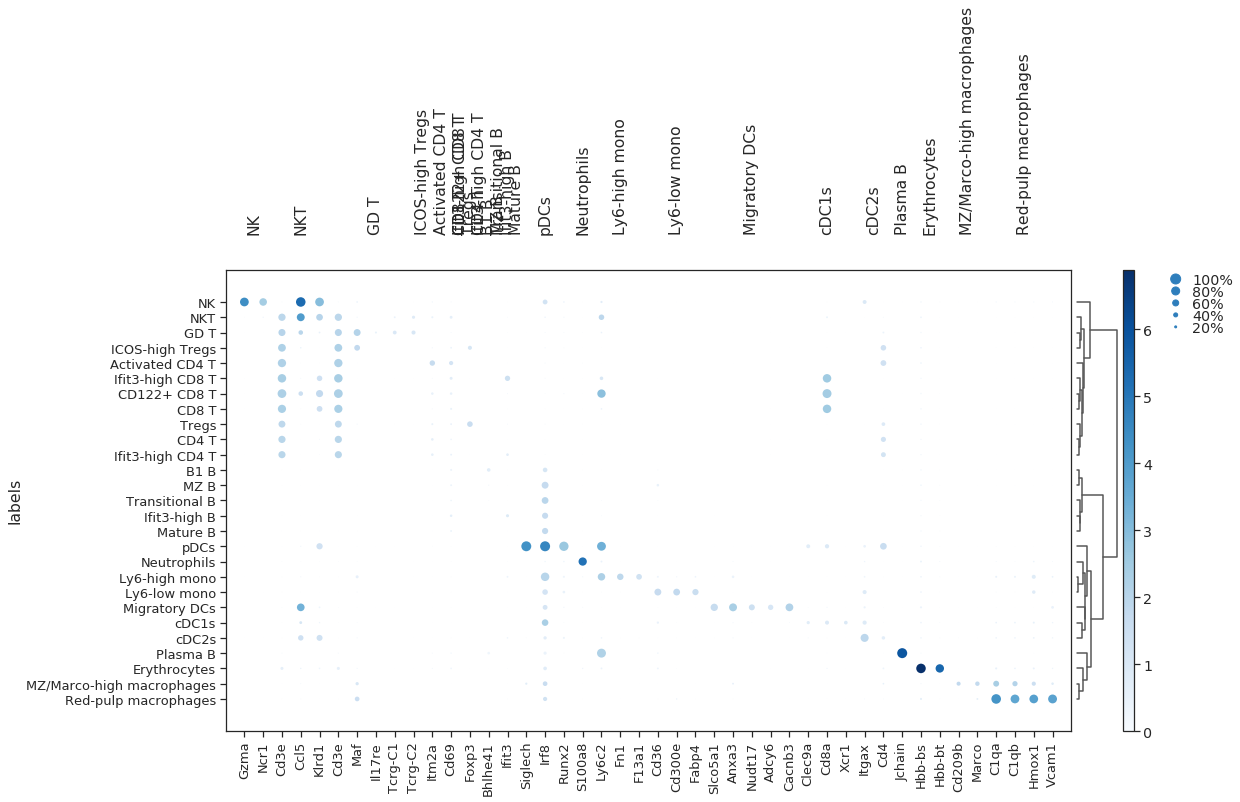

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[15.399999999999999, 0.8, 0.2, 0.5, 0.25])

In [31]:
sc.pl.dotplot(
    adata_total,
    groupby="labels",
    var_names=label_groups_new,
    dendrogram=True,
    color_map="Blues",
    save="_rna_markers.pdf",
)

In [38]:
prodata = anndata.AnnData(np.log1p(dataset.protein_expression)[include_cells])
parsed_protein_names = [p.split("_")[1].split("(")[0] for p in dataset.protein_names]
prodata.var_names = parsed_protein_names
prodata.obs["labels"] = adata_total.obs["labels"].values
prodata.uns["dendrogram_labels"] = adata_total.uns["dendrogram_labels"]

In [39]:
prodata.var_names

Index(['CD102', 'CD103', 'CD106', 'CD115', 'CD117', 'CD11a', 'CD11c', 'CD122',
       'CD127', 'CD134',
       ...
       'TCRVr1.1-Cr4', 'TCRVr2', 'TCRVr3', 'TCRbchain', 'TCRr-d',
       'TER-119-ErythroidCells', 'Tim-4', 'XCR1', 'anti-P2RY12', 'integrinb7'],
      dtype='object', length=110)

In [42]:
label_groups = {
    'B1 B': ["CD19", "CD43"],
    'CD122+ CD8 T': ["CD122", "CD62L", "CD8a", "CD183"],
    'CD4 T': ["CD4"],
    'cDC1s': ["CD11c"],
    'ICOS-high Tregs': ["CD278"],
    'Tregs': ["CD357"],
    "Mature B": ["IgD", "CD23", "CD19"],
    "MZ B": ["CD21-CD35", "CD19"],
    "Transitional B": ["CD93", "CD24"],
    "CD8 T": ["CD8a", "CD8b"],
    'Red-pulp macrophages': ["F4-80"],
}
label_groups_new = {}
for ct in np.unique(adata_total.obs["labels"]):
    if ct not in label_groups.keys():
        label_groups_new[ct] = []
    else:
        label_groups_new[ct] = label_groups[ct]

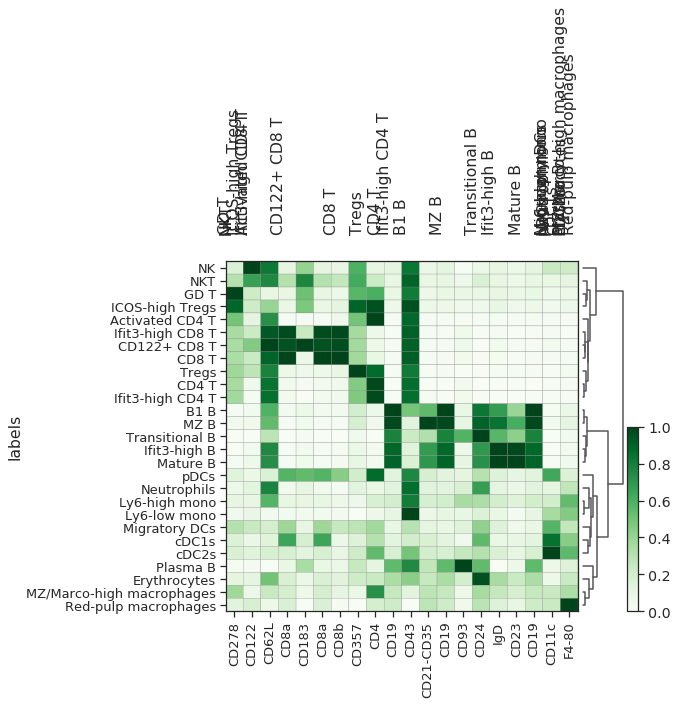

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[6.4, 0.8, 0.2])

In [43]:
sc.pl.matrixplot(
    prodata,
    groupby="labels",
    var_names=label_groups_new,
    dendrogram=True,
    use_raw=False,
    standard_scale="var",
    cmap="Greens",
    save="_pro_markers.pdf",
)